## Simple RNN language model to predict plausible dinosaur names - part 1

The decision to do a language model based on dinosaur names was inspired by a project I had when working on a deep learning course offered by Deeplearning.ai. The data used within this notebook was found [here]("https://github.com/brunoklein99/deep-learning-notes") and consists of a list of dinosaur names. I initially started out to develop a simple architecture and found myself wondering how different changes to the model architecture might either improve or make a language model worse. I use cross-entropy loss with logits, and to specifically measure the performance of different models, I compare the last cost to the initial cost to see what the percentage decrease is for any given change. I compare two architectures at a time with a winner-take-all system in which the best model at a given step is then tested at the next step. Each model will implemented with gradient clipping and be trained for 30 epochs with a lr = 0.01 and then 2 epochs at a lr = 0.005.

Below I set out the 5 unique ways in which I test out different architectures to see if there is an improvement in the model performance:

1. Standatd LSTM cells with 512 hidden units using a cost of using three input characters to predict the single next chacter

2. Standard LSTM cells with 512 hidden units using a cost of using three input characters to predict the three next chacters with respect to the input sequence

3. Standard LSTM cells with 512 hidden units using a dense layer before the softmax output and uses the most effective cost method from the first two methods.

4. Standard LSTM cells with 512 hidden units using the best method (softmax or dense->softmax) and the optimal cost method with a longer sequence to see if there is an increase in performance. (a shorter sequence was not tested as the cost method of predicting the next three characters already takes into account predicting characters given shorter sequences)

5. Using a standard rnn architecture of rnn cells simply with tanh activations and no memory gates using all of the optimal methods within part 4


Within this particular notebook, I test out the first two models. As described earlier, the better performing model will be used in the next round to be compared with method 3. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
from sklearn.utils import shuffle
np.random.seed(10)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [2]:
# Reading in data - creating dictionaries specifying how to encode data (into characters)
chars = []
all_names = []
with open("../../data/dino_names/names.txt") as names:
    lines = names.readlines()
    for line in lines:
        line = line.lower()
        for char in line:
            if char not in chars:
                chars.append(char)
        all_names.append(line) # \n included
                
print(chars)
print("no chars:",len(chars))

['a', 'c', 'h', 'e', 'n', 'o', 's', 'u', 'r', '\n', 'd', 'y', 'x', 'b', 'l', 'i', 't', 'p', 'v', 'm', 'g', 'f', 'j', 'k', 'w', 'z', 'q']
no chars: 27


In [3]:
# Analysis of the names set
print(len(all_names))
print("max char len:", len(max(all_names,key=len)))
print("min char len:", len(min(all_names,key=len)))

1536
max char len: 27
min char len: 4


In [4]:
# Creating encoder and decoder
i = 1
encoder = {"\n":0} # char to id, set \n to be 0
decoder = {0:"\n"} # id to char

for char in chars:
    if char != "\n":
        encoder[char] = i
        decoder[i] = char
        i += 1

In [5]:
# returns one hot encoding for a particular character
def get_one_hot_encoding(char):
    char_enc = encoder[char]
    hot_vec = np.zeros((27,1)) # vocab_size = 27
    hot_vec[char_enc] = 1
    hot_vec = hot_vec.T # shape (1,27)
    return hot_vec

In [6]:
# Returns the one_hot_encoding representation for a set of characters, i.e. "abc"
def get_character_encoding(chars):
    ret_enc = []
    for c in chars:
        c_one_hot = get_one_hot_encoding(c) # one_hot_encoding
        ret_enc.append(c_one_hot)
        
    ret_enc = np.array(ret_enc)
    ret_enc.shape = (3,27)
    return ret_enc

In [7]:
# returns a list of ((3,27),(1,27)) pairs corresponding with ((x_train_set),(y_output))
def get_training_examples(lis_names,seed):
    shuf_names = shuffle(lis_names,random_state=seed) # shuffling order of names
    training_set = []
    
    for name in lis_names:
        m = len(name)
        i = 3
        while i < m: # this means we won't overrun the number of chars in a name
            x_temp = get_character_encoding(name[i-3:i])
            y_temp = get_one_hot_encoding(name[i]) # x^<t+1>
            training_set.append((x_temp,y_temp))
            i += 1
            
    return training_set

In [8]:
# Getting initial training set / testing func.
training_set = get_training_examples(all_names,seed=0)
print("Number of training examples:", len(training_set))
print("x shape:", training_set[100][0].shape)
print("y shape:", training_set[100][1].shape)

Number of training examples: 15301
x shape: (3, 27)
y shape: (1, 27)


### Building model which uses one softmax output to compute loss - MODEL 1

In [9]:
# placeholders for model 1
# predicting one word only, so y shape = (1,num_chars)
def get_placeholders():
    X = tf.placeholder(tf.float32, shape=[3, 27], name='X')
    y = tf.placeholder(tf.float32, shape=[1, 27], name='Y')
    return X,y

In [10]:
# Defining the rnn block with lstm cells for model 1
def rnn_cell(the_input,n_input=3):
    the_input = tf.split(the_input, n_input, axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=512,activation=tf.nn.tanh) # 512 hidden units per cell
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,dtype=tf.float32) # output for each input
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    out = tf.layers.dense(flat,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer()) # logits, 27D output
    return out # returns logits

In [11]:
# cost function used for both model 1 and model 2
# Cross entropy loss because we are comparing the output of y^<t> and x^<t+1> for an arbitrary input sequence len
def cost_function(logits,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=logits))

In [12]:
# Testing rnn cells and cost function for model 1
tf.reset_default_graph()
x,y = get_placeholders()
logits = rnn_cell(x)
cost = cost_function(logits,y)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    acost = sess.run(cost,feed_dict={x:training_set[100][0],y:training_set[100][1]})
    print(acost)

3.328307


In [35]:
# Model for language model using stochastic gradient descent w/ gradient clipping
# Note - this model builds the computation graph for both model 1 and model 2
def model(names_set,lr=0.01,num_epochs=15,print_cost=True,retrain=True,model1=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    
    if model1: # using model 1
        x,y = get_placeholders()
        logits = rnn_cell(x)
    else: # using model 2
        x,y = get_placeholders2()
        logits = rnn_cell2(x)
    cost = cost_function(logits,y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    grads, variables = zip(*optimizer.compute_gradients(cost))
    grads, _ = tf.clip_by_global_norm(grads, 5.0) # gradient clipping
    optimizer = optimizer.apply_gradients(zip(grads, variables))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        if retrain:
            if model1: # use model 1 to continue training
                saver = tf.train.import_meta_graph("../../data/dino_names/model/language_model.ckpt.meta")
                saver.restore(sess, "../../data/dino_names/model/language_model.ckpt")
            else: # use model 2 to continue training
                saver = tf.train.import_meta_graph("../../data/dino_names/model2/language_model.ckpt.meta")
                saver.restore(sess, "../../data/dino_names/model2/language_model.ckpt")
        else:
            sess.run(init) # only run init when you are training a new model

        for epoch in range(num_epochs):
            old_running_cost = 0 # used to print out the increase to total cost each step
            running_cost = 0
            seed += 1
            if model1:
                training_set = get_training_examples(names_set,seed)
            else:
                training_set = get_training_examples2(names_set,seed)
                
            for aset in training_set:
                (ax,ay) = aset
                _,temp_cost = sess.run([optimizer,cost], feed_dict={x:ax,y:ay})
                running_cost += temp_cost
                
                if print_cost: # print each training example cost update
                    one_step_cost = running_cost - old_running_cost
                    print("Step cost:",one_step_cost)
                    old_running_cost += temp_cost
                
            costs.append(running_cost)
            if (epoch+1) % 1 == 0: # printing costs
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                
            if (epoch+1) % 3 == 0: # save model every three epoch
                if model1:
                    loc = saver.save(sess, "../../data/dino_names/model/language_model.ckpt")
                else:
                    loc = saver.save(sess, "../../data/dino_names/model2/language_model.ckpt")
        
        # save model once more once training is complete
        if model1:
            loc = saver.save(sess, "../../data/dino_names/model/language_model.ckpt")
        else:
            loc = saver.save(sess, "../../data/dino_names/model2/language_model.ckpt")
        return costs

In [53]:
acosts1 = model(all_names,lr=0.01,num_epochs=30,print_cost=False,retrain=False)

Cost at epoch 1: 25351.687621803954
Cost at epoch 2: 22001.783078623375
Cost at epoch 3: 20335.594542323848
Cost at epoch 4: 19063.959569256927
Cost at epoch 5: 18199.930159021023
Cost at epoch 6: 17459.363595034374
Cost at epoch 7: 17075.95508049745
Cost at epoch 8: 16872.01777623087
Cost at epoch 9: 16490.51161030396
Cost at epoch 10: 16232.312919180227
Cost at epoch 11: 16353.662010788317
Cost at epoch 12: 16158.763027611356
Cost at epoch 13: 16253.157042901124
Cost at epoch 14: 16258.579187020416
Cost at epoch 15: 16635.54854227798
Cost at epoch 16: 16370.128277285861
Cost at epoch 17: 16522.879588683205
Cost at epoch 18: 16874.99381262077
Cost at epoch 19: 16736.93957086139
Cost at epoch 20: 16880.0320827266
Cost at epoch 21: 17425.94609177695
Cost at epoch 22: 17119.14995725909
Cost at epoch 23: 16730.897301489502
Cost at epoch 24: 17005.072792743318
Cost at epoch 25: 16911.630104823507
Cost at epoch 26: 17232.242128715956
Cost at epoch 27: 17056.99726678295
Cost at epoch 28: 177

In [54]:
acosts2 = model(all_names,lr=0.005,num_epochs=2,print_cost=False,retrain=True)

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model/language_model.ckpt
Cost at epoch 1: 13874.489991506316
Cost at epoch 2: 11909.582915918014


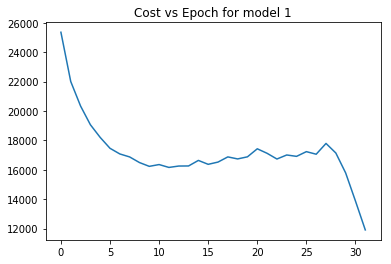

model 1 percentage change: 0.4697747579405746


In [55]:
total_costs1 = acosts1 + acosts2
ax_i = [i for i in range(len(total_costs1))]
plt.plot(ax_i,total_costs1)
plt.title("Cost vs Epoch for model 1")
plt.show()
print("model 1 percentage change:",total_costs1[-1]/total_costs1[0])

In [18]:
# This sample cell samples the model in order to create a dinosaur name
def sample_cell(the_input,a,c):
    past_state = (a,c)
    the_input = tf.split(the_input,1,axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=512,activation=tf.nn.tanh) # 512 hidden units per cell
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,initial_state=past_state,dtype=tf.float32) # output for each input
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    out = tf.layers.dense(flat,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer()) # logits, 27D output
    out = tf.nn.softmax(out)
    achar = tf.argmax(out,axis=-1)
    achar = tf.reshape(achar,()) # character in int representation
    return achar,curr_state # returns logits

In [59]:
# Sampling the characters and ensuring the hidden state is updating each time step, from model 1
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[1, 27])
a = tf.placeholder(tf.float32, shape=[1, 512])
c = tf.placeholder(tf.float32, shape=[1, 512])
out = sample_cell(x,a,c)

ax = get_one_hot_encoding("l")
out_char = -1
i = 0 # counts timesteps

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph("../../data/dino_names/model/language_model.ckpt.meta")
saver.restore(sess, "../../data/dino_names/model/language_model.ckpt")

print("l") # first character
while out_char != 0 and i < 6:
    if i == 0:
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:np.zeros((1,512)),c:np.zeros((1,512))})
        out_char = achar
        a_past_state = past_state
    else:
        print("sampled char:",decoder[achar]) # print character
        a_a = past_state[0]
        a_c = past_state[1]
        ax = get_one_hot_encoding(decoder[achar])
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:a_a,c:a_c})
        out_char = achar
        print("state a difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[0],past_state[0]))) # sanity check
        print("state c difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[1],past_state[1])))
        a_past_state = past_state
        
    i += 1

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model/language_model.ckpt
l
sampled char: o
state a difference at 1: 9.329215
state c difference at 1: 0.45990437
sampled char: c
state a difference at 2: -8.7732115
state c difference at 2: -0.42222527
sampled char: i
state a difference at 3: 16.162529
state c difference at 3: 1.8428881
sampled char: s
state a difference at 4: -16.37145
state c difference at 4: -4.2320986
sampled char: a
state a difference at 5: -18.313978
state c difference at 5: -18.118649


### Training a language model using clusters of y variables, such that at any given point y<sup>t</sup> is attempting to predict x<sup>t+1</sup> for a sequence of length 3 - MODEL 2

This differs from earlier training in that the y data is in sets of three clusters: shape(3,27) rather than (1,27). I am testing this to see if there is a performance improvement over the one output softmax model above.

In [25]:
# returns a list of ((3,27),(3,27)) pairs corresponding with ((x_train_set),(y_output))
def get_training_examples2(lis_names,seed):
    shuf_names = shuffle(lis_names,random_state=seed) # shuffling order of names
    training_set = []
    
    for name in lis_names:
        m = len(name)
        i = 3
        while i < m: # this means we won't overrun the number of chars in a name
            x_temp = get_character_encoding(name[i-3:i])
            y_temp = get_character_encoding(name[i-2:i+1]) # x^<t+1>
            training_set.append((x_temp,y_temp))
            i += 1
            
    return training_set

In [26]:
# Getting initial training set / testing func.
training_set2 = get_training_examples2(all_names,seed=0)
print("Number of training examples:", len(training_set2))
print("x shape:", training_set2[100][0].shape)
print("y shape:", training_set2[100][1].shape)

Number of training examples: 15301
x shape: (3, 27)
y shape: (3, 27)


In [34]:
# placeholder function for model 2
def get_placeholders2():
    X = tf.placeholder(tf.float32, shape=[3, 27], name='X')
    y = tf.placeholder(tf.float32, shape=[3, 27], name='Y')
    return X,y

In [30]:
# Defining the rnn block with lstm cells for model 2, multiple outputs
def rnn_cell2(the_input,n_input=3):
    the_input = tf.split(the_input, n_input, axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=512,activation=tf.nn.tanh) # 512 hidden units per cell
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,dtype=tf.float32) # output for each input
    
    flats = [tf.layers.flatten(out) for out in outputs] # flatten all outputs
    out = [tf.layers.dense(flat,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(),reuse=tf.AUTO_REUSE,name="out2") for flat in flats]

    return out # returns logits shape:(3,27)

In [47]:
# Testing rnn cells and cost function for model 2
tf.reset_default_graph()
x,y = get_placeholders2()
logits = rnn_cell2(x)
cost = cost_function(logits,y)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    alogits = sess.run(logits,feed_dict={x:training_set2[100][0],y:training_set2[100][1]})
    acost = sess.run(cost,feed_dict={x:training_set2[100][0],y:training_set2[100][1]})
    print(acost)
    print(len(alogits)) # three output logits, each of shape (1,27)
    print(alogits[0].shape)

3.2813303
3
(1, 27)


In [48]:
acosts1_2 = model(all_names,lr=0.01,num_epochs=30,print_cost=False,retrain=False,model1=False)

Cost at epoch 1: 28755.944729174487
Cost at epoch 2: 27130.30936356075
Cost at epoch 3: 26413.89690341754
Cost at epoch 4: 25838.534138939343
Cost at epoch 5: 25383.48333191406
Cost at epoch 6: 25093.63515411876
Cost at epoch 7: 24709.333341025747
Cost at epoch 8: 24603.555900692474
Cost at epoch 9: 24488.009772976337
Cost at epoch 10: 24320.640451534884
Cost at epoch 11: 24197.787657008972
Cost at epoch 12: 23945.17895105388
Cost at epoch 13: 24109.969193848316
Cost at epoch 14: 24003.142630041577
Cost at epoch 15: 24319.904619313776
Cost at epoch 16: 23836.38036400359
Cost at epoch 17: 23706.81246945262
Cost at epoch 18: 23810.844961984083
Cost at epoch 19: 23804.395439034328
Cost at epoch 20: 23671.3024658449
Cost at epoch 21: 23716.122535487637
Cost at epoch 22: 23569.07189572975
Cost at epoch 23: 23709.36378868483
Cost at epoch 24: 23643.585512259044
Cost at epoch 25: 23796.3549305778
Cost at epoch 26: 23738.058931378648
Cost at epoch 27: 23548.40046333894
Cost at epoch 28: 23706.

In [51]:
acosts2_2 = model(all_names,lr=0.005,num_epochs=2,print_cost=False,retrain=True,model1=False)

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model2/language_model.ckpt
Cost at epoch 1: 22655.270631609485
Cost at epoch 2: 22238.77230563201


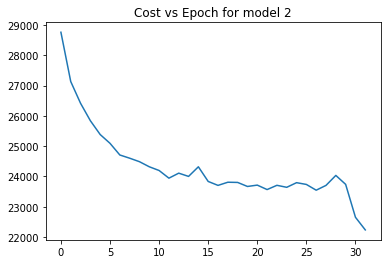

model 2 percentage change: 0.7733626043268038


In [56]:
total_costs2 = acosts1_2 + acosts2_2
ax_i2 = [i for i in range(len(total_costs2))]
plt.plot(ax_i2,total_costs2)
plt.title("Cost vs Epoch for model 2")
plt.show()
print("model 2 percentage change:",total_costs2[-1]/total_costs2[0])

In [63]:
# This sample cell samples the model in order to create a dinosaur name
def sample_cell2(the_input,a,c):
    past_state = (a,c)
    the_input = tf.split(the_input,1,axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=512,activation=tf.nn.tanh) # 512 hidden units per cell
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,initial_state=past_state,dtype=tf.float32) # output for each input
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    out = tf.layers.dense(flat,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(),reuse=tf.AUTO_REUSE,name="out2") # logits, 27D output
    out = tf.nn.softmax(out)
    achar = tf.argmax(out,axis=-1)
    achar = tf.reshape(achar,()) # character in int representation
    return achar,curr_state # returns logits

In [77]:
# Sampling the characters and ensuring the hidden state is updating each time step, from model 2
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[1, 27])
a = tf.placeholder(tf.float32, shape=[1, 512])
c = tf.placeholder(tf.float32, shape=[1, 512])
out = sample_cell2(x,a,c)
input_char = "z"
ax = get_one_hot_encoding(input_char)
out_char = -1
i = 0 # counts timesteps

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph("../../data/dino_names/model2/language_model.ckpt.meta")
saver.restore(sess, "../../data/dino_names/model2/language_model.ckpt")

print(input_char) # first character
while out_char != 0 and i < 8:
    if i == 0:
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:np.zeros((1,512)),c:np.zeros((1,512))})
        out_char = achar
        a_past_state = past_state
    else:
        print("sampled char:",decoder[achar]) # print character
        a_a = past_state[0]
        a_c = past_state[1]
        ax = get_one_hot_encoding(decoder[achar])
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:a_a,c:a_c})
        out_char = achar
        print("state a difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[0],past_state[0]))) # sanity check
        print("state c difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[1],past_state[1])))
        a_past_state = past_state
        
    i += 1

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model2/language_model.ckpt
z
sampled char: h
state a difference at 1: 6.128443
state c difference at 1: -0.19699511
sampled char: o
state a difference at 2: -1.8080018
state c difference at 2: 0.28743368
sampled char: n
state a difference at 3: 3.0209372
state c difference at 3: -2.2347364
sampled char: g
state a difference at 4: -16.01978
state c difference at 4: 3.4217541
sampled char: o
state a difference at 5: 33.405457
state c difference at 5: 13.166895
sampled char: s
state a difference at 6: 36.539436
state c difference at 6: 4.7498055
sampled char: a
state a difference at 7: 32.80292
state c difference at 7: 15.5264435
